# Simple sentiment analysis from Telkomsel review googe playstore
- Made by Muhammad Dava Pasha (mdavap) @ Dicoding

# Resources
- Lexicon @ https://github.com/fajri91/InSet

## Import

In [1]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

## Setup NTLK

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

## Accessing data

In [3]:
data = pd.read_csv("./data.csv")
data.head()

,Review
0,"Saya sangat tidak suka fitur auto log-out nya,..."
1,Animasi dan UI sekarang terlalu over bikin gak...
2,"Apk sering terjadi bug. Slow refresh, miss not..."
3,"Aplikasi my Telkomsel sungguh luar biasa,, Buk..."
4,Semenjak Indihome diintegrasikan ke Telkomsel ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108000 entries, 0 to 107999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  108000 non-null  object
dtypes: object(1)
memory usage: 843.9+ KB


In [5]:
print(f'Jumlah duplikasi pada data adalah {data.duplicated().sum()}')

Jumlah duplikasi pada data adalah 44


In [6]:
data.drop_duplicates(inplace=True)

In [7]:
print(f'Jumlah duplikasi sekarang pada data adalah {data.duplicated().sum()}')

Jumlah duplikasi sekarang pada data adalah 0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107956 entries, 0 to 107999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  107956 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


## Sentiment Analysis

### Make a transformer

In [9]:
stopwords = nltk.corpus.stopwords.words('indonesian')

# Clean text
def clean_text(input: str):
    # Lower the input
    lowered_text = input.lower()
    # Replace newline with space
    removed_newline = lowered_text.replace('\n', ' ')
    # Remove special characters
    removed_special = removed_newline.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    removed_digit = ''.join([ch for ch in removed_special if not ch.isdigit()])
    # Remove unicode things like emoji and so on
    removed_unicode = removed_digit.encode('ascii', errors='ignore').decode('ascii')
    # Remove stop words
    removed_stopwords = ''.join([word for word in removed_unicode if not word in stopwords])
    # Remove unused spaces
    return removed_stopwords.strip()

# Transform text into tokenized list
def clean_and_tokenize(input: str):
    cleaned = clean_text(input)
    return nltk.word_tokenize(cleaned)

def to_sentence(input: list):
    return ' '.join(input)

### Clean and Tokenize everything

In [ ]:
print('Transforming... Please wait...')
data['Transformed'] = data['Review'].apply(clean_and_tokenize)
print('Transform is finished!')

Transforming... Please wait...
Transform is finished!


In [11]:
data['Sentence'] = data['Transformed'].apply(to_sentence)

### Load lexicon data

In [12]:
positive_df = pd.read_csv('./lexicon/positive.tsv', sep='\t')
negative_df = pd.read_csv('./lexicon/negative.tsv', sep='\t')
positive_df.head(5)

,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2


In [13]:
negative_df.head(5)

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5


In [14]:
positive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    3609 non-null   object
 1   weight  3609 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.5+ KB


In [15]:
negative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    6609 non-null   object
 1   weight  6609 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 103.4+ KB


### Labeling using lexicon data

In [16]:
# Convert lexicon dataframe to dict word:weight
positive_lexicon = dict()
negative_lexicon = dict()

for i, row in positive_df.iterrows():
    positive_lexicon[row['word']] = row['weight']

for i, row in negative_df.iterrows():
    negative_lexicon[row['word']] = row['weight']

In [17]:
def get_score_using_lexicon(input: list):
    score = 0

    # Add positive score
    for word in input:
        if word in positive_lexicon:
            score += positive_lexicon[word]

    # Add negative score
    for word in input:
        if word in negative_lexicon:
            score += negative_lexicon[word]

    sentiment = 'positive' if score >= 0 else 'negative'
    return score, sentiment


result_score = data['Transformed'].apply(get_score_using_lexicon)


In [18]:
result_score = list(zip(*result_score))

In [19]:
data['score_sentiment'] = result_score[0]
data['sentiment'] = result_score[1]

In [20]:
data.head(5)

,Review,Transformed,Sentence,score_sentiment,sentiment
0,"Saya sangat tidak suka fitur auto log-out nya,...","[saya, sangat, tidak, suka, fitur, auto, logou...",saya sangat tidak suka fitur auto logout nya d...,-25,negative
1,Animasi dan UI sekarang terlalu over bikin gak...,"[animasi, dan, ui, sekarang, terlalu, over, bi...",animasi dan ui sekarang terlalu over bikin gak...,-31,negative
2,"Apk sering terjadi bug. Slow refresh, miss not...","[apk, sering, terjadi, bug, slow, refresh, mis...",apk sering terjadi bug slow refresh miss notif...,-34,negative
3,"Aplikasi my Telkomsel sungguh luar biasa,, Buk...","[aplikasi, my, telkomsel, sungguh, luar, biasa...",aplikasi my telkomsel sungguh luar biasa bukan...,-60,negative
4,Semenjak Indihome diintegrasikan ke Telkomsel ...,"[semenjak, indihome, diintegrasikan, ke, telko...",semenjak indihome diintegrasikan ke telkomsel ...,-48,negative


In [21]:
sentiments = data['sentiment'].value_counts()
sentiments

sentiment
negative    82929
positive    25027
Name: count, dtype: int64

### Visualisasi

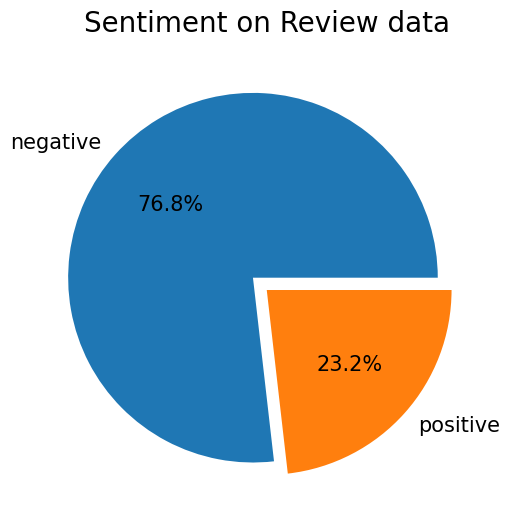

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in sentiments]
labels = sentiments.index
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=(0.1, 0), textprops={'fontsize': 15})
ax.set_title('Sentiment on Review data', fontsize=20, pad=20)
plt.show()

## Machine learning

In [23]:
t_vectorizer = TfidfVectorizer(max_features=800, min_df=20, max_df=0.8)
x_result = t_vectorizer.fit_transform(data['Sentence'])

In [24]:
x_result.shape

(107956, 800)

In [25]:
features_df = pd.DataFrame(x_result.toarray(), columns=t_vectorizer.get_feature_names_out())
features_df.head(5)

,abis,ad,ada,adalah,adanya,admin,agak,agar,aj,aja,...,walaupun,wifi,wilayah,xl,ya,yaa,yah,yang,yg,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.185395,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.231379,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.218171,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.136966,0.0,0.0,0.0,0.064991,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.243163,0.0,0.0


### Label encoding

In [26]:
label_encoder = LabelEncoder()
y_target = label_encoder.fit_transform(data['sentiment'])

### Split data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_result, y_target, test_size=0.2, random_state=100)

In [28]:
x_train.shape

(86364, 800)

In [29]:
y_test.shape

(21592,)

In [30]:
x_train = x_train.toarray()
x_test = x_test.toarray()

### Main Machine Learning using Logistic Regression

In [31]:
logistic_regression = LogisticRegression()

logistic_regression.fit(x_train, y_train)

train_result = logistic_regression.predict(x_train)
test_result = logistic_regression.predict(x_test)

accuracy_train = accuracy_score(train_result, y_train)
accuracy_test_lr = accuracy_score(test_result, y_test)

print(f'Logistic Regression on training data with accuracy: {accuracy_train}')
print(f'Logistic Regression on test data with accuracy: {accuracy_test_lr}')

Logistic Regression on training data with accuracy: 0.9374739474781159
Logistic Regression on test data with accuracy: 0.9337254538718044


#### Inference with trained Logistic Regression

In [32]:
def get_sentiment_analysis(input: pd.DataFrame):
    index = input.index
    prediction = logistic_regression.predict(x_result[index].toarray())
    return label_encoder.inverse_transform(prediction)[0]

# Inference with 10 sample
for i in range(10):
    sample = data.sample(1)
    sentiment = get_sentiment_analysis(sample)
    review = sample["Review"].values[0]
    print(f'Sentiment: {sentiment} with review "{review}"')

Sentiment: negative with review "Paket ekstra kuota harian untuk halo pilihannya sekarang gak guna, masih lebih baik ekstra kuota harian yang lama, kecewa sama telkomsel, siap2 cari provider lain"
Sentiment: negative with review "Makin mengecewakan masa dapet kuota hadiah dari daily check in malah ga kepake yg keambil kuota utama sangat kecewa, tidak membantu pengguna"
Sentiment: negative with review "Sinyalnya n jaringan PD knp ini min dari kmrin.. 😭 dh beli kuota mhal2 tpi gini.. tlong tingkatn lagi kualitas nya min..thx nanti 🌟 naik dh. Skrg mlh ga bs pembayaran ke lainnya.. 🤦ampun dh psing"
Sentiment: positive with review "Harga paket mahal,kualitas gitu2 aja. Seharusnya pemakaian kuota itu harus balance, jangan sedot kuota utama jika sedang YT ataupun multimedia lainnya. Kan jadi sayang kuota utama habis dan waktu paketnya juga habis pas sebulan yg kuota multimedia masih utuh. Saya biasa beli paket combo 52 GB (30 utama, 20 multimedia). Tolong perbaikilah supaya Untuk pemakaian in

### Schema 1
- Logistic Regression
- Split data 70/30

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_result, y_target, test_size=0.3, random_state=500)

In [34]:
logistic_regression = LogisticRegression()

logistic_regression.fit(x_train, y_train)

train_result = logistic_regression.predict(x_train)
test_result = logistic_regression.predict(x_test)

accuracy_train = accuracy_score(train_result, y_train)
accuracy_test = accuracy_score(test_result, y_test)

print(f'Logistic Regression [0.3] on training data with accuracy: {accuracy_train}')
print(f'Logistic Regression [0.3] on test data with accuracy: {accuracy_test}')

Logistic Regression [0.3] on training data with accuracy: 0.936574521298416
Logistic Regression [0.3] on test data with accuracy: 0.931515731620712


### Schema 2
- Logistic Regression
- Bag of Words (BoW)

In [35]:
vectorizer = CountVectorizer(max_features=800)
bow_matrix = vectorizer.fit_transform(data['Sentence'])

features_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
features_df.head(5)

,abis,ad,ada,adalah,adanya,admin,agak,agar,aj,aja,...,walaupun,wifi,wilayah,xl,ya,yaa,yah,yang,yg,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [36]:
x_train, x_test, y_train, y_test = train_test_split(bow_matrix, y_target, test_size=0.2, random_state=100)

In [37]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [38]:
logistic_regression = LogisticRegression()

logistic_regression.fit(x_train, y_train)

train_result = logistic_regression.predict(x_train)
test_result = logistic_regression.predict(x_test)

accuracy_train = accuracy_score(train_result, y_train)
accuracy_test = accuracy_score(test_result, y_test)

print(f'Logistic Regression (BoW) on training data with accuracy: {accuracy_train}')
print(f'Logistic Regression (BoW) on test data with accuracy: {accuracy_test}')

Logistic Regression (BoW) on training data with accuracy: 0.9444444444444444
Logistic Regression (BoW) on test data with accuracy: 0.9385420526120786


### Schema 3
- SGDClassifier
- Bag of Words (BoW)

In [39]:
sgdclassifier = SGDClassifier()

sgdclassifier.fit(x_train, y_train)

train_result = sgdclassifier.predict(x_train)
test_result = sgdclassifier.predict(x_test)

accuracy_train = accuracy_score(train_result, y_train)
accuracy_test = accuracy_score(test_result, y_test)

print(f'SGDClassifier (BoW) on training data with accuracy: {accuracy_train}')
print(f'SGDClassifier (BoW) on test data with accuracy: {accuracy_test}')

SGDClassifier (BoW) on training data with accuracy: 0.9402991987402158
SGDClassifier (BoW) on test data with accuracy: 0.9342812152649129
